In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import label, generate_binary_structure
from skimage import (
    io,
    color,
    measure,
    img_as_float,
    img_as_uint,
    img_as_ubyte,
    exposure,
    morphology,
    feature,
)
from skimage.segmentation import clear_border, felzenszwalb, mark_boundaries
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.filters import (
    hessian,
    frangi,
    sobel,
    meijering,
    sato,
    threshold_multiotsu,
    scharr,
    try_all_threshold,
    threshold_otsu,
)
from skimage.util import invert
from os.path import join, exists
import os
from PIL import Image

Image.MAX_IMAGE_PIXELS = 2000000000

In [2]:
import pandas as pd
import sys
import os
from pathlib import Path

project_root = Path.cwd().parents[0]  # Move one level up from current directory
sys.path.append(str(project_root))
from utils import utils
from utils.utils import *

In [3]:
# Set matplotlib backend
%matplotlib inline 
# %matplotlib notebook 
# %matplotlib qt#

## Loading image

In [4]:
# List of images to be analyzed
NEEM_path = "../data/raw-images/"
# images_list = ["nmx3658b_1.png","nmx3658b_2.png","nmx3684b_1.png","nmx3684b_2.png","nmx3667b_1.png","nmx3667b_2.png","nmx3664d_1.png","nmx3664d_2.png"]
images_list = ["nmx3661b_1.png"]
slicing_param = pd.read_csv("../data/slicing_param.csv")

# Define image parameters
pixels_to_um = 5  # pixels to um relation
crop_img_len = 6  # length of cropped images [cm] 1cm=2000px
overlap = 1  # length of overlap of cropped images [cm]

# Convert from cm to px
crop_img_len_px = int(
    crop_img_len * (1 / pixels_to_um) * 10000
)  # length of one image in px
overlap_px = int(overlap * (1 / pixels_to_um) * 10000)
slicing_param.tail(10)

name  px_left  px_top  px_bottom  px_right
65  nmx3642b_1    59023     888       6814    117782
66  nmx3642b_2    58998    1784       5950    117757
67  nmx3658b_1     4903     700       5188    114776
68  nmx3658b_2     4881     180       4900    114754
69  nmx3684b_1     5085    2468       6876    113742
70  nmx3684b_2     5062    1865       6200    113719
71  nmx3667b_1     6574    3250       6611    115044
72  nmx3667b_2     6555    1593       5100    115025
73  nmx3664d_1     5460     800       6360    115544
74  nmx3664d_2     5435    1338       5360    115519

In [5]:
# Function definition
def load_full_image(file_name, file_path, len_crop_img_px, overlap_px, df_slicing):
    """
    Load image from given path and calculate slicing parameters.
    """
    df_slic_img = df_slicing[df_slicing["name"] == file_name[:-4]]
    img_path = join(file_path, file_name)
    img = io.imread(img_path)
    total_length = df_slic_img["px_right"].iloc[0] - df_slic_img["px_left"].iloc[0]
    n = int((total_length - overlap_px) / (len_crop_img_px - overlap_px))
    print("Image loaded")
    return img, n, df_slic_img


# Ensure slicing_param and other inputs are correctly initialized as per your first message
# Assuming slicing_param is already loaded and formatted correctly

# Define the file name and path (these can be adjusted as needed)
file_name = "nmx3661b_1.png"
file_path = "../data/raw-images/"
len_crop_img_px = crop_img_len_px
overlap_px = overlap_px
df_slicing = slicing_param

Image loaded
Number of cropped images: 10
Slicing parameters for the image:
          name  px_left  px_top  px_bottom  px_right
26  nmx3661b_1     4790     350       8192    114600


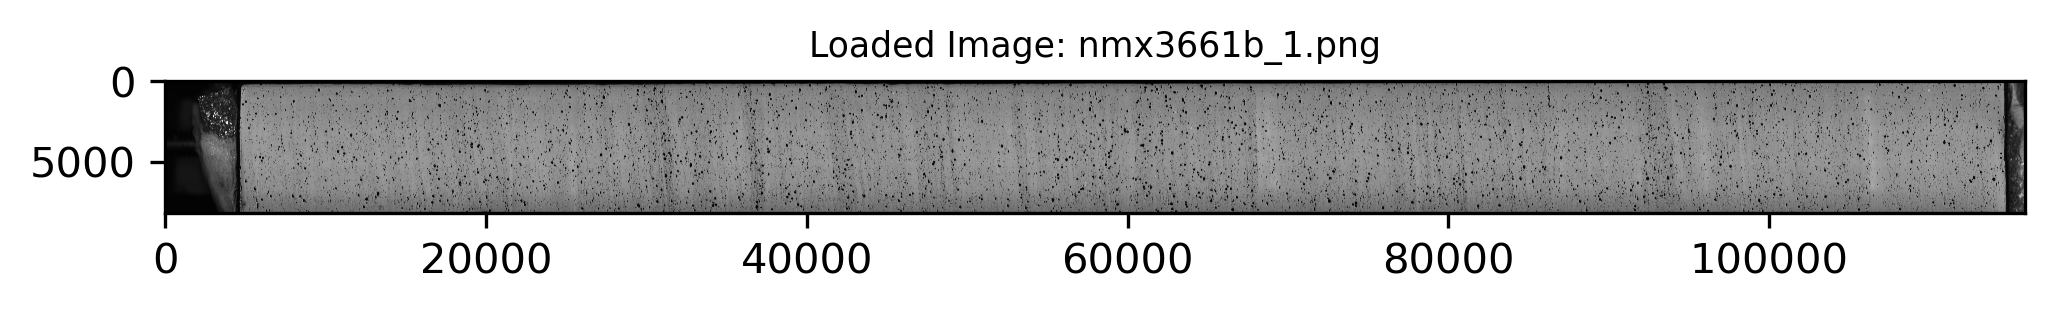

In [6]:
# Call the function
img, n, df_slic_img = load_full_image(
    file_name, file_path, len_crop_img_px, overlap_px, df_slicing
)

# Display the loaded image
fig = create_figure(figsize=(8, 4))
ax = plt.subplot()
show_image(img, pos=(111), axis=True, title=(f"Loaded Image: {file_name}"), axes=ax)

# Output the number of cropped images and the slicing parameters for the specific image
print(f"Number of cropped images: {n}")
print("Slicing parameters for the image:")
print(df_slic_img)

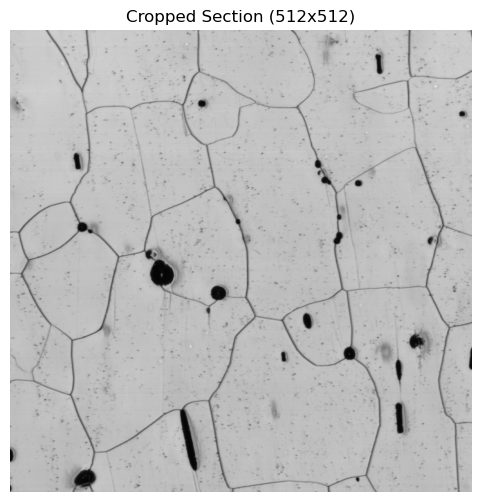

In [7]:
# Define the crop size and the starting position
crop_size = 1024  # Crop size (512x512)
x_start, y_start = 10000, 5000  # Example starting position for cropping

# Crop the section
cropped_img = img[y_start : y_start + crop_size, x_start : x_start + crop_size]

# Display the cropped image
plt.figure(figsize=(6, 6))
plt.imshow(cropped_img, cmap="gray")
plt.title("Cropped Section (512x512)")
plt.axis("off")
plt.show()

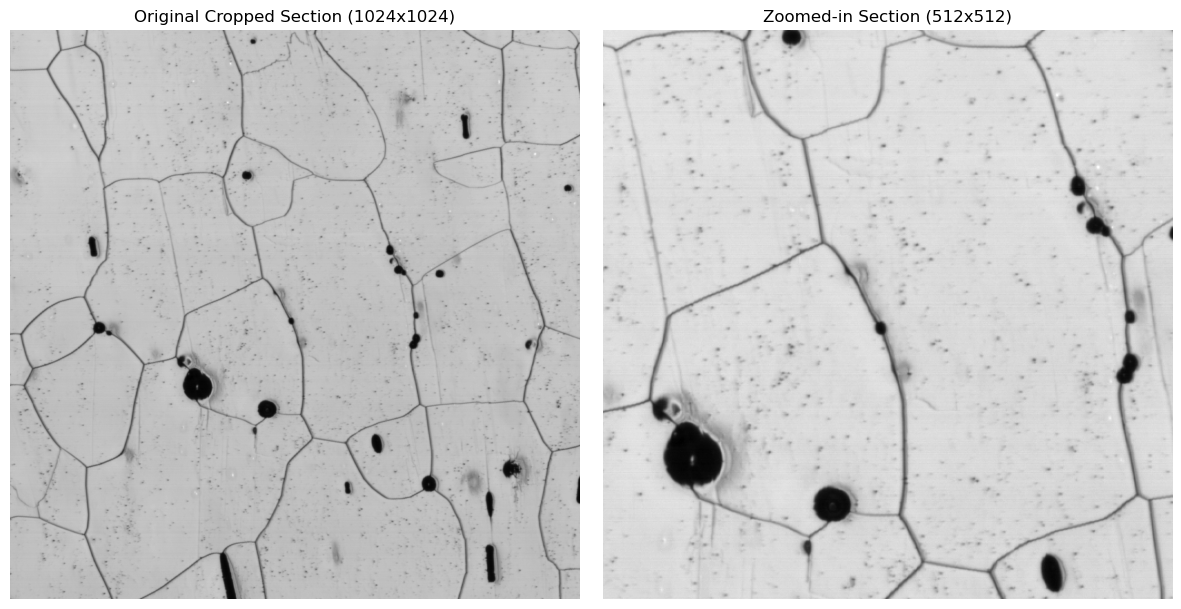

In [8]:
# Define the crop size and the starting position
crop_size = 1024  # Initial crop size
x_start, y_start = 10000, 4900  # Starting position for cropping

# Crop the section
cropped_img = img[y_start : y_start + crop_size, x_start : x_start + crop_size]

# Define zoom-in parameters
zoom_factor = 2  # Zoom in by a factor of 2
zoom_crop_size = crop_size // zoom_factor
zoom_x_start, zoom_y_start = crop_size // 4, crop_size // 4  # Centered zoom in

# Perform the zoomed crop
zoomed_img = cropped_img[
    zoom_y_start : zoom_y_start + zoom_crop_size,
    zoom_x_start : zoom_x_start + zoom_crop_size,
]

# Display both the original cropped image and the zoomed-in section
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original crop
axes[0].imshow(cropped_img, cmap="gray")
axes[0].set_title("Original Cropped Section (1024x1024)")
axes[0].axis("off")

# Zoomed-in crop
axes[1].imshow(zoomed_img, cmap="gray")
axes[1].set_title("Zoomed-in Section (512x512)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

Image denoised and rescaled
Image denoised and rescaled


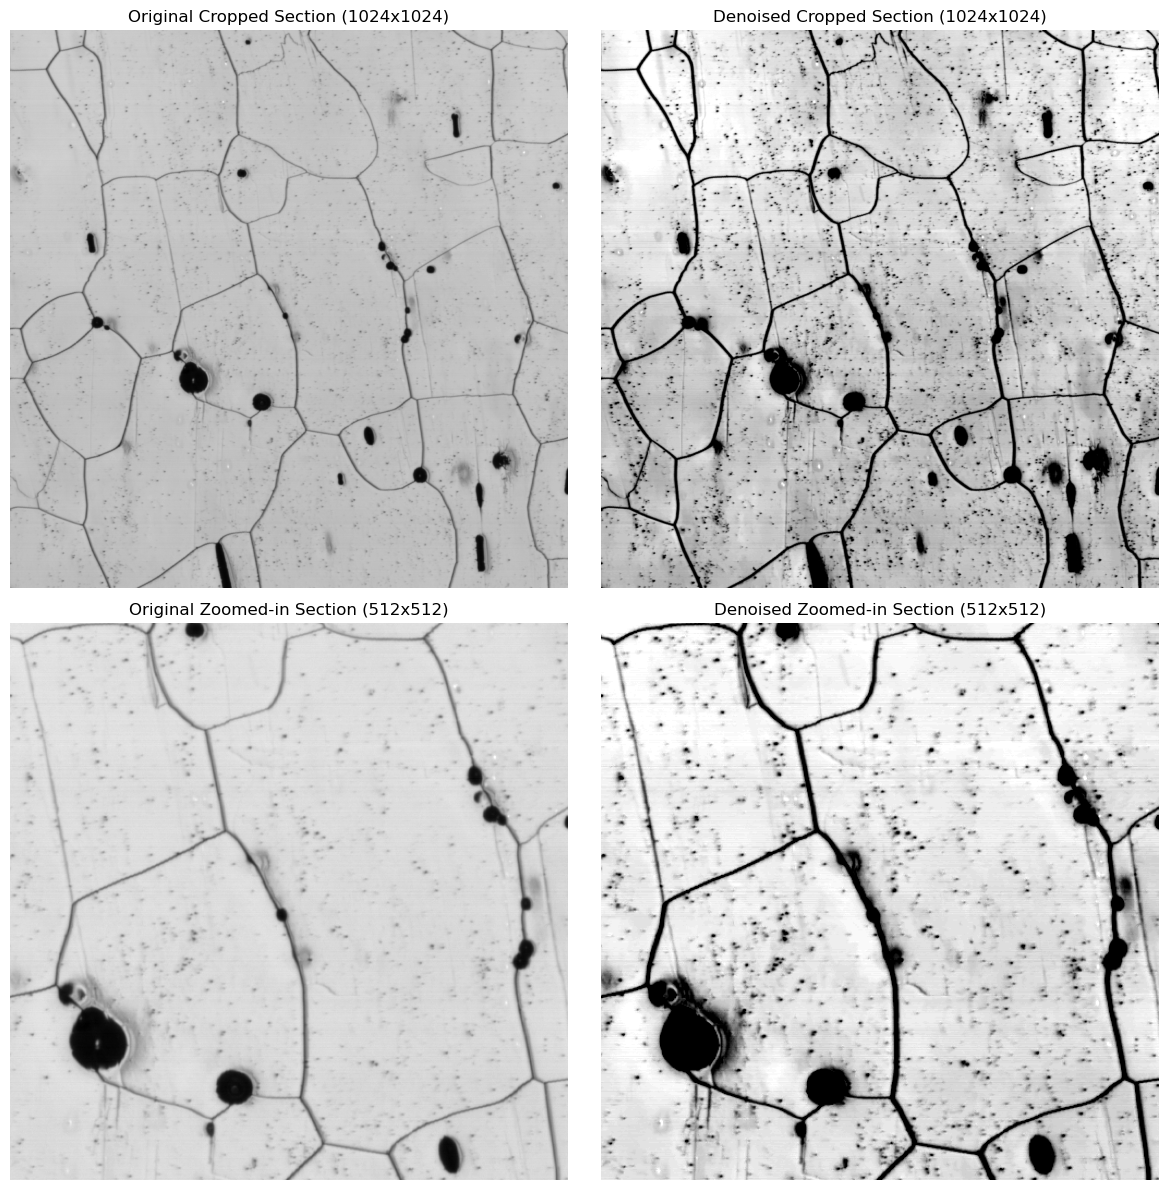

In [173]:
# Ensure all necessary libraries are imported
from skimage import restoration, util, exposure
import numpy as np
from skimage.color import rgb2gray
from skimage import img_as_float, img_as_ubyte


# Define the denoise function
def denoise(image):
    """
    Apply non-local means denoising and intensity rescale.
    """
    img_float = img_as_float(image)
    sigma_est = np.mean(restoration.estimate_sigma(img_float, channel_axis=None))
    patch_kw = dict(
        patch_size=5,  # 5x5 patches
        patch_distance=9,  # 13x13 search area
        channel_axis=None,
    )  # None for greyscale image
    img_denoised = restoration.denoise_nl_means(
        img_float, h=0.6 * sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw
    )
    img_denoised_uint = img_as_ubyte(img_denoised)
    p2, p95 = np.percentile(img_denoised_uint, (5, 99))
    rescaled = exposure.rescale_intensity(img_denoised_uint, in_range=(p2, p95))
    print("Image denoised and rescaled")
    return rescaled


# Apply the denoise function to both the original cropped image and the zoomed-in image
denoised_cropped_img = denoise(cropped_img)
denoised_zoomed_img = denoise(zoomed_img)

# Display the original and denoised images for comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Original cropped image
axes[0, 0].imshow(cropped_img, cmap="gray")
axes[0, 0].set_title("Original Cropped Section (1024x1024)")
axes[0, 0].axis("off")

# Denoised cropped image
axes[0, 1].imshow(denoised_cropped_img, cmap="gray")
axes[0, 1].set_title("Denoised Cropped Section (1024x1024)")
axes[0, 1].axis("off")

# Original zoomed-in image
axes[1, 0].imshow(zoomed_img, cmap="gray")
axes[1, 0].set_title("Original Zoomed-in Section (512x512)")
axes[1, 0].axis("off")

# Denoised zoomed-in image
axes[1, 1].imshow(denoised_zoomed_img, cmap="gray")
axes[1, 1].set_title("Denoised Zoomed-in Section (512x512)")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

Hessian filter applied
Hessian filter applied


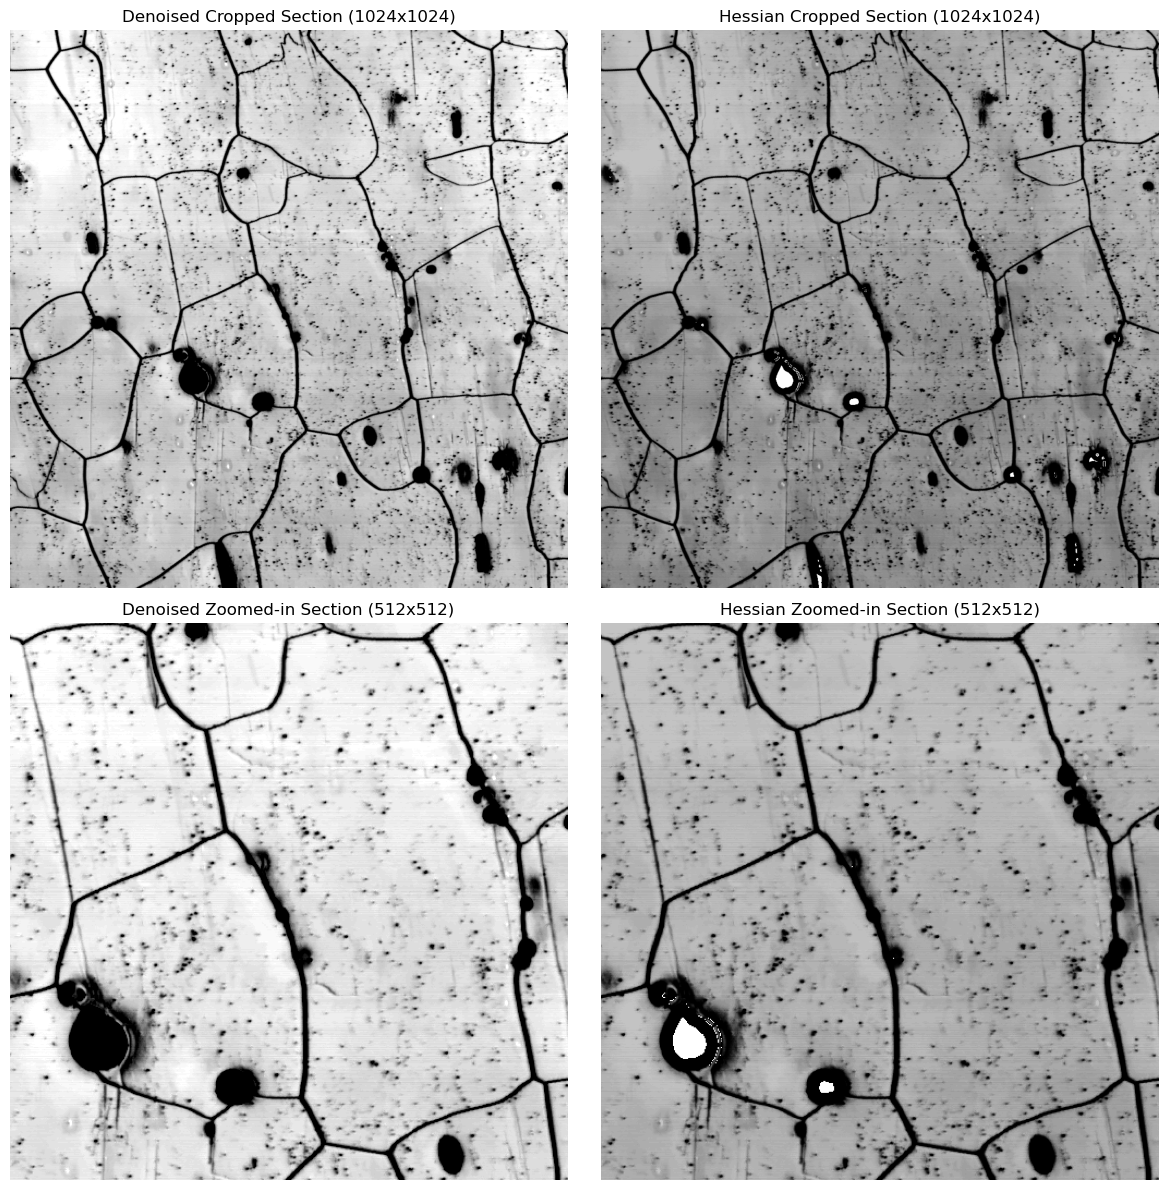

In [177]:
# Hypothetical import, assuming 'hessian' is a function you have access to
from skimage.filters import hessian


def hessian_filter(image):
    """
    Apply a Hessian-based filter to enhance features or edges in an image.
    """
    # The parameters used here are illustrative; adjust them as needed
    # hessian_img = hessian(image, sigmas=[0, 2], alpha=.5, beta=.5, gamma=15, black_ridges=True, mode='reflect', cval=0)
    hessian_img = hessian(
        image,
        sigmas=[0.0, 2],
        alpha=0.5,
        beta=0.5,
        gamma=300,
        black_ridges=True,
        mode="reflect",
        cval=0,
    )
    print("Hessian filter applied")
    return hessian_img


# Apply the Hessian filter to the denoised images
hessian_cropped_img = hessian_filter(denoised_cropped_img)
hessian_zoomed_img = hessian_filter(denoised_zoomed_img)

# Display the denoised and Hessian-filtered images for comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Denoised cropped image
axes[0, 0].imshow(denoised_cropped_img, cmap="gray")
axes[0, 0].set_title("Denoised Cropped Section (1024x1024)")
axes[0, 0].axis("off")

# Hessian-filtered cropped image
axes[0, 1].imshow(hessian_cropped_img, cmap="gray")
axes[0, 1].set_title("Hessian Cropped Section (1024x1024)")
axes[0, 1].axis("off")

# Denoised zoomed-in image
axes[1, 0].imshow(denoised_zoomed_img, cmap="gray")
axes[1, 0].set_title("Denoised Zoomed-in Section (512x512)")
axes[1, 0].axis("off")

# Hessian-filtered zoomed-in image
axes[1, 1].imshow(hessian_zoomed_img, cmap="gray")
axes[1, 1].set_title("Hessian Zoomed-in Section (512x512)")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

Hessian filter applied
Hessian filter applied


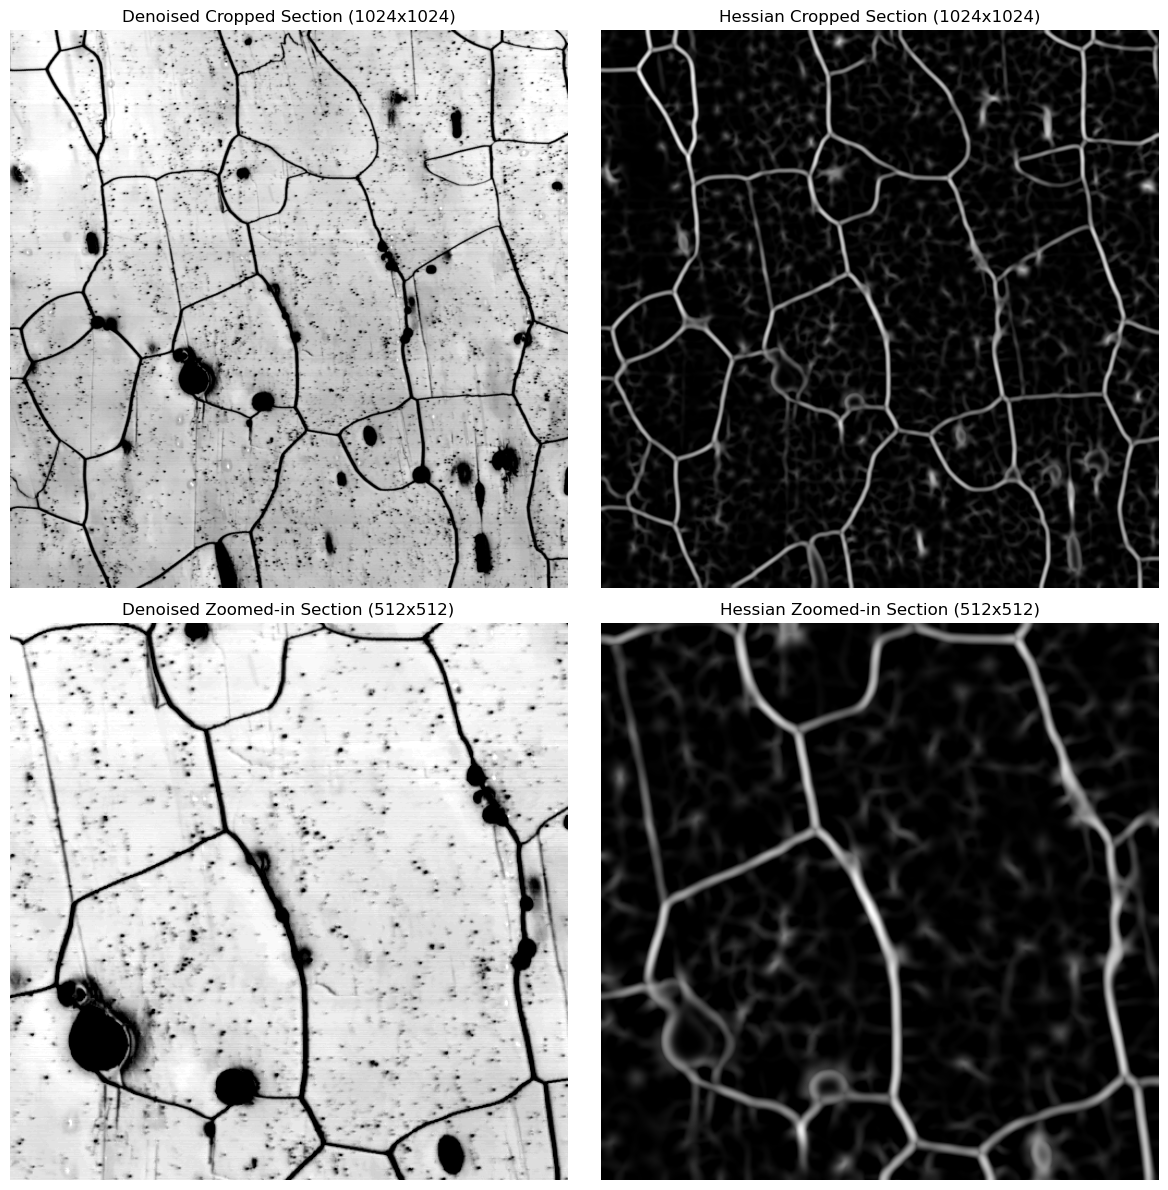

In [186]:
# Hypothetical import, assuming 'hessian' is a function you have access to
from skimage.filters import hessian, sato


def hessian_filter(image):
    """
    Apply a Hessian-based filter to enhance features or edges in an image.
    """
    # The parameters used here are illustrative; adjust them as needed
    # hessian_img = hessian(image, sigmas=[0, 2], alpha=.5, beta=.5, gamma=15, black_ridges=True, mode='reflect', cval=0)
    hessian_img = sato(
        image,
        sigmas=[0.1, 5.5],
        # alpha=0.5,
        # beta=0.5,
        # gamma=300,
        black_ridges=True,
        mode="reflect",
        cval=0,
    )
    print("Hessian filter applied")
    return hessian_img


# Apply the Hessian filter to the denoised images
hessian_cropped_img = hessian_filter(denoised_cropped_img)
hessian_zoomed_img = hessian_filter(denoised_zoomed_img)

# Display the denoised and Hessian-filtered images for comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Denoised cropped image
axes[0, 0].imshow(denoised_cropped_img, cmap="gray")
axes[0, 0].set_title("Denoised Cropped Section (1024x1024)")
axes[0, 0].axis("off")

# Hessian-filtered cropped image
axes[0, 1].imshow(hessian_cropped_img, cmap="gray")
axes[0, 1].set_title("Hessian Cropped Section (1024x1024)")
axes[0, 1].axis("off")

# Denoised zoomed-in image
axes[1, 0].imshow(denoised_zoomed_img, cmap="gray")
axes[1, 0].set_title("Denoised Zoomed-in Section (512x512)")
axes[1, 0].axis("off")

# Hessian-filtered zoomed-in image
axes[1, 1].imshow(hessian_zoomed_img, cmap="gray")
axes[1, 1].set_title("Hessian Zoomed-in Section (512x512)")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

Cleaned image
Cleaned image


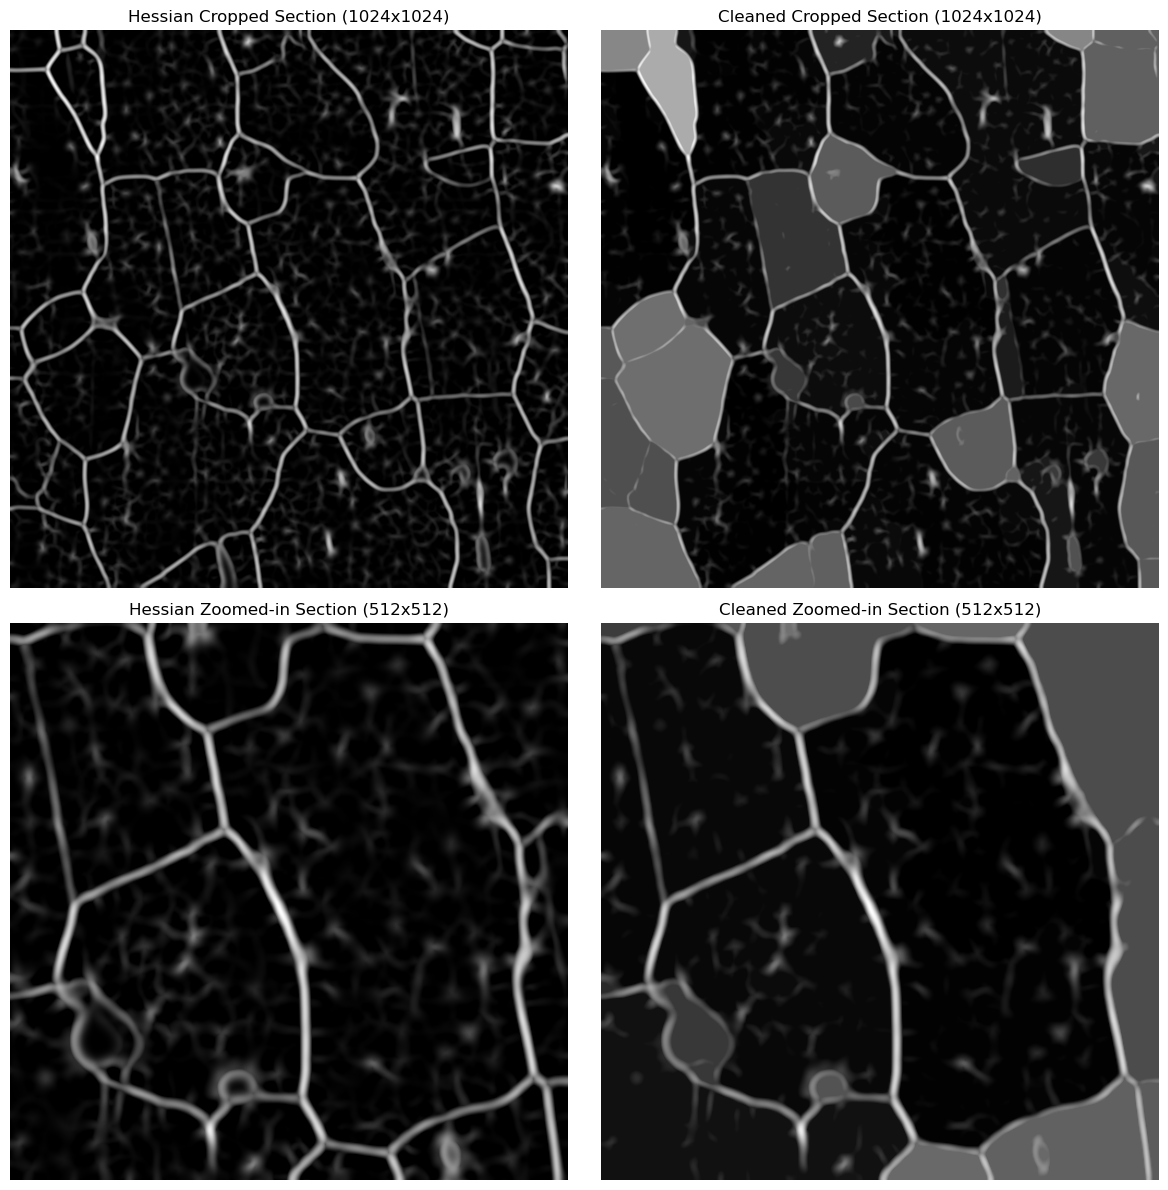

In [187]:
# Import necessary libraries
import numpy as np
from skimage import morphology


def cleaning(image, mask):
    """
    Perform morphological filtering to clean the image using the provided mask.
    """
    # Subtract the mask from the image and ensure no negative values
    image_bubbles = image - mask
    image_bubbles = np.where(image_bubbles < 0, 0, image_bubbles)
    # Apply diameter closing to clean the image
    clean_image = morphology.diameter_closing(image_bubbles, diameter_threshold=250)
    print("Cleaned image")
    return clean_image


# For demonstration, we'll create a hypothetical binary mask (adjust this as per your data)
mask_cropped = (denoised_cropped_img > np.percentile(denoised_cropped_img, 99)).astype(
    np.uint8
)
mask_zoomed = (denoised_zoomed_img > np.percentile(denoised_zoomed_img, 99)).astype(
    np.uint8
)

# Apply the cleaning function
cleaned_cropped_img = cleaning(hessian_cropped_img, mask_cropped)
cleaned_zoomed_img = cleaning(hessian_zoomed_img, mask_zoomed)

# Display the original Hessian-filtered and cleaned images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Hessian-filtered cropped image
axes[0, 0].imshow(hessian_cropped_img, cmap="gray")
axes[0, 0].set_title("Hessian Cropped Section (1024x1024)")
axes[0, 0].axis("off")

# Cleaned cropped image
axes[0, 1].imshow(cleaned_cropped_img, cmap="gray")
axes[0, 1].set_title("Cleaned Cropped Section (1024x1024)")
axes[0, 1].axis("off")

# Hessian-filtered zoomed-in image
axes[1, 0].imshow(hessian_zoomed_img, cmap="gray")
axes[1, 0].set_title("Hessian Zoomed-in Section (512x512)")
axes[1, 0].axis("off")

# Cleaned zoomed-in image
axes[1, 1].imshow(cleaned_zoomed_img, cmap="gray")
axes[1, 1].set_title("Cleaned Zoomed-in Section (512x512)")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()